<a href="https://colab.research.google.com/github/Ashwin1999/COVID-19-Data-Mining/blob/master/COVID_19_Data_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("dark")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


import dataset from this link: https://github.com/Ashwin1999/COVID-19-Data-Mining

In [2]:
testing_india=pd.read_csv('https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/master/COVID-Data(India)/StatewiseTestingDetails.csv')
testing_india.head()

,Date,State,TotalSamples,Negative,Positive
0,2020-04-17,Andaman and Nicobar Islands,1403.0,1210,12.0
1,2020-04-24,Andaman and Nicobar Islands,2679.0,NaN,27.0
2,2020-04-27,Andaman and Nicobar Islands,2848.0,NaN,33.0
3,2020-05-01,Andaman and Nicobar Islands,3754.0,NaN,33.0
4,2020-05-16,Andaman and Nicobar Islands,6677.0,NaN,33.0


# Reshaping our dataframe

In [3]:
files = [
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/master/COVID-Time%20Series%20Data/time_series_covid_19_confirmed.csv',
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/master/COVID-Time%20Series%20Data/time_series_covid_19_confirmed_US.csv',
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/master/COVID-Time%20Series%20Data/time_series_covid_19_deaths.csv',
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/master/COVID-Time%20Series%20Data/time_series_covid_19_deaths_US.csv',
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/master/COVID-Time%20Series%20Data/time_series_covid_19_recovered.csv,'
]

In [4]:
df = pd.read_csv(files[0])
confirmed = df.melt(['Province/State', 'Country/Region'], df.columns[4:], var_name='Dates', value_name='Count')
confirmed.Dates = pd.to_datetime(confirmed.Dates)
confirmed.head()

,Province/State,Country/Region,Dates,Count
0,NaN,Afghanistan,2020-01-22,0
1,NaN,Albania,2020-01-22,0
2,NaN,Algeria,2020-01-22,0
3,NaN,Andorra,2020-01-22,0
4,NaN,Angola,2020-01-22,0


In [5]:
df = pd.read_csv(files[1])
confirmed_US = df.melt(['Province_State', 'Country_Region'], df.columns[11:], var_name='Dates', value_name='Count')
confirmed_US.rename(columns={"Province_State": "Province/State", "Country_Region": "Country/Region"}, inplace=True)
confirmed_US.Dates = pd.to_datetime(confirmed_US.Dates)
confirmed_US.head()

,Province/State,Country/Region,Dates,Count
0,Alabama,US,2020-01-22,0
1,Alabama,US,2020-01-22,0
2,Alabama,US,2020-01-22,0
3,Alabama,US,2020-01-22,0
4,Alabama,US,2020-01-22,0


In [6]:
df = pd.read_csv(files[2])
deaths = df.melt(['Province/State', 'Country/Region'], df.columns[4:], var_name='Dates', value_name='Count')
deaths.Dates = pd.to_datetime(deaths.Dates)
deaths.head()

,Province/State,Country/Region,Dates,Count
0,NaN,Afghanistan,2020-01-22,0
1,NaN,Albania,2020-01-22,0
2,NaN,Algeria,2020-01-22,0
3,NaN,Andorra,2020-01-22,0
4,NaN,Angola,2020-01-22,0


In [7]:
df = pd.read_csv(files[3])
deaths_US = df.melt(['Province_State', 'Country_Region'], df.columns[12:], var_name='Dates', value_name='Count')
deaths_US.rename(columns={"Province_State": "Province/State", "Country_Region": "Country/Region"}, inplace=True)
deaths_US.Dates = pd.to_datetime(deaths_US.Dates)
deaths_US.head()

,Province/State,Country/Region,Dates,Count
0,Alabama,US,2020-01-22,0
1,Alabama,US,2020-01-22,0
2,Alabama,US,2020-01-22,0
3,Alabama,US,2020-01-22,0
4,Alabama,US,2020-01-22,0


In [8]:
df = pd.read_csv('https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/master/COVID-Time%20Series%20Data/time_series_covid_19_recovered.csv')
recovered = df.melt(['Province/State', 'Country/Region'], df.columns[4:], var_name='Dates', value_name='Count')
recovered.Dates = pd.to_datetime(recovered.Dates)
recovered.head()

,Province/State,Country/Region,Dates,Count
0,NaN,Afghanistan,2020-01-22,0
1,NaN,Albania,2020-01-22,0
2,NaN,Algeria,2020-01-22,0
3,NaN,Andorra,2020-01-22,0
4,NaN,Angola,2020-01-22,0


# Growth rate of COVID-19

In [9]:
df1 = confirmed.groupby('Dates').sum().reset_index()
df2 = deaths.groupby('Dates').sum().reset_index()
df3 = recovered.groupby('Dates').sum().reset_index()

cdr = pd.DataFrame({
    'date': df1.Dates,
    'confirmed': df1.Count,
    'deaths': df2.Count,
    'recovered': df3.Count,
})

cdr.head()

,date,confirmed,deaths,recovered
0,2020-01-22,555,17,28
1,2020-01-23,654,18,30
2,2020-01-24,941,26,36
3,2020-01-25,1434,42,39
4,2020-01-26,2118,56,52


In [10]:
cdr = cdr.melt('date', cdr.columns[1:], var_name='condition', value_name='count')
cdr.head()

,date,condition,count
0,2020-01-22,confirmed,555
1,2020-01-23,confirmed,654
2,2020-01-24,confirmed,941
3,2020-01-25,confirmed,1434
4,2020-01-26,confirmed,2118


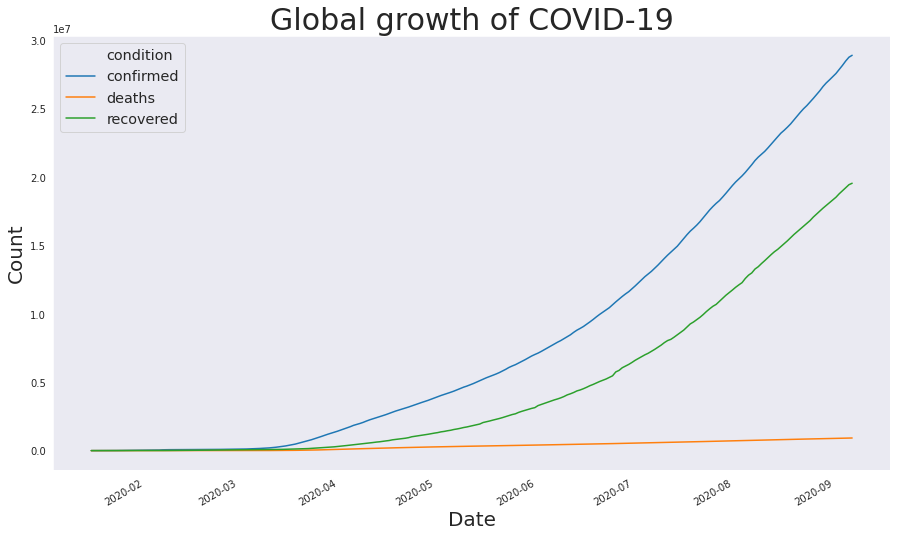

In [11]:
plt.figure(figsize=(15,8));

growth = sns.lineplot(cdr["date"], cdr["count"], hue=cdr["condition"]);

growth.set_title("Global growth of COVID-19",fontsize=30);
growth.set_xlabel("Date",fontsize=20);
growth.set_ylabel("Count",fontsize=20);

plt.xticks(rotation=30);
plt.legend(fontsize='x-large');

# Country wise report of COVID-19 cases

In [12]:
countrywise_confirmed = confirmed.groupby(['Country/Region']).sum().reset_index()
countrywise_deaths = deaths.groupby(['Country/Region']).sum().reset_index()
countrywise_recovered = recovered.groupby(['Country/Region']).sum().reset_index()

countrywise_cdr = pd.DataFrame({
    'country': countrywise_confirmed['Country/Region'],
    'confirmed': countrywise_confirmed.Count,
    'deaths': countrywise_deaths.Count,
    'recovered': countrywise_recovered.Count,
})

countrywise_cdr.head()

,country,confirmed,deaths,recovered
0,Afghanistan,3745342,114595,2139148
1,Albania,583139,17360,329905
2,Algeria,3088876,145505,2089806
3,Andorra,145841,7952,111054
4,Angola,125569,5483,45985


In [13]:
temp1 = countrywise_cdr.sort_values('confirmed', ascending=False).head(20)
temp2 = countrywise_cdr.sort_values('deaths', ascending=False).head(20)
temp3 = countrywise_cdr.sort_values('recovered', ascending=False).head(20)

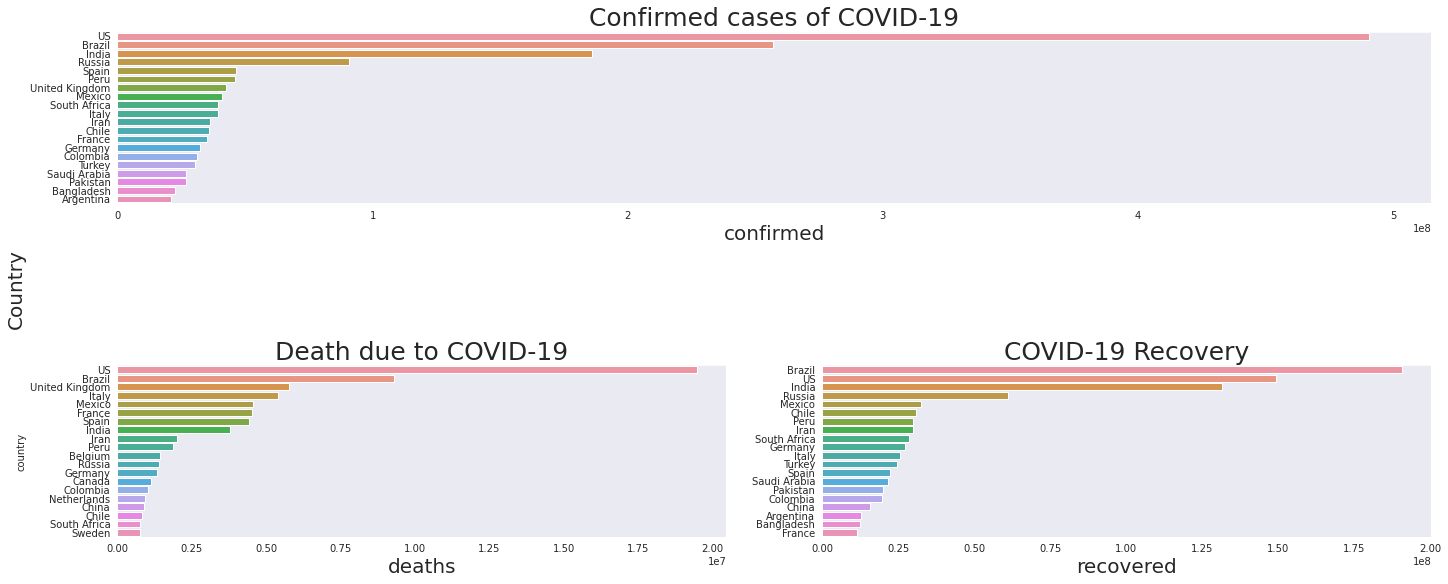

In [14]:
fig3 = plt.figure(constrained_layout=True, figsize=(20,8));
gs = fig3.add_gridspec(2, 2);

f3_ax1 = fig3.add_subplot(gs[0, :]);
f3_ax1.set_title('Confirmed cases of COVID-19',fontsize=25);
f3_ax1.set_xlabel("Number of people recovered",fontsize=20);
sns.barplot(temp1["confirmed"], temp1["country"],ax=f3_ax1);

f3_ax2 = fig3.add_subplot(gs[1, :1]);
f3_ax2.set_title('Death due to COVID-19',fontsize=25);
f3_ax2.set_xlabel("Number of people recovered",fontsize=20);
sns.barplot(temp2["deaths"], temp2["country"],ax=f3_ax2);

f3_ax2 = fig3.add_subplot(gs[1, 1:]);
f3_ax2.set_title('COVID-19 Recovery',fontsize=25);
f3_ax2.set_xlabel("Number of people recovered",fontsize=20);
sns.barplot(temp3["recovered"], temp3["country"],ax=f3_ax2);


f3_ax1.set_ylabel("Country",fontsize=20, position=(0,-0.5));
f3_ax2.set_ylabel(" ",fontsize=0);
f3_ax2.set_ylabel(" ",fontsize=0);